# All kinds of data preprocessing operation for clinical notes, time series data and tabular data

This is the first step of all the iHMNNF project, which consisting of the codes for information extraction from the original data in database
- 0-Remove duplicate "initial medical record" entries for the same visit.
- 1-Perform initial semi-structured decomposition of the "initial medical record" entries.
- 2-Extract age and gender information based on the aforementioned semi-structured "initial medical record" entries.
- 3-Extract symptom descriptions from the aforementioned semi-structured "initial medical record" entries.
- 4-Extract differential diagnoses from the aforementioned semi-structured "initial medical record" entries.
- 5-Extract symptom descriptions from the "chief complaint" text.
- 6-Extract personal history information from the "personal history" text.
- 7-Extract past medical history information from the "past medical history" text.
- 8-Generalize the extracted symptom descriptions from the "chief complaint" and "initial course of illness" texts.
- 9-Merge and remove duplicates from the extracted symptom descriptions from the "chief complaint" and "initial course of illness" texts.
- 10-Extract height and weight information
- 11-Import the first version of label data provided by clinicians into the LABEL table.
- 12-Complete the labels based on the diag_append field in the CONDITION table.
- 13-Complete the labels based on the medication data in the DRUG table, and merge labels from multiple sources.
- 14-Handle outliers in numerical and categorical variables in the laboratory data.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config.orcl import db_connection
from src.TextRegex import TextRegex, TextGeneralization
from src.Preprocessing import NoDup, FirstRecordSplit, HeightAndWeight, LabelProcess, SymAndChiefcom, SymAndChiefcomV2, LabelComplement, LabelCV, MeasurementProcess, FeatureAggre, FeatureAggreV2, LabelComplementV2

# plt.rc("font",family="Times New Roman",size="12") 
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #解决负号“-”显示为方块的问题

Duplicate key in file PosixPath('/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 251 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 259 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, SimHei, Times New Roman, Times')
Duplicate key in file PosixPath('/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 402 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')
Duplicate key in file '/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc', line 259 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, s

### 0-Remove duplicate "initial medical record" entries for the same visit.

In [2]:
nd = NoDup('fuo', 'ORIGIN_NOTE_DUP')
nd.process() # 已执行

[VISIT_RECORD_ID]:ZY_4081404
[VISIT_RECORD_ID]:ZY_3975150
[VISIT_RECORD_ID]:ZY_4103848
[VISIT_RECORD_ID]:ZY_4052760
[VISIT_RECORD_ID]:ZY_4242231
[VISIT_RECORD_ID]:ZY_4265903


KeyboardInterrupt: 

### 1-Perform initial semi-structured decomposition of the "initial medical record" entries.

In [ ]:
def first_record_split(db_name, input_table, output_table):
    """
    Args:
        db_name: the orcl of database
        input_table: the source table of 首次病程记录
        output_table: the table containing the semi-structured data
    Returns:
        No returns, all the results will be inserted into output_table
    """
    frs = FirstRecordSplit(db_name, input_table, output_table)  
    note_id = frs.getnoteidlist('首次病程记录')
    count = 0
    if not os.path.exists('./log'):
        os.makedirs('./log')
    logpath = os.path.join(os.path.abspath('.'), 'log/log_prepro.txt')
    for i in note_id:
        print("============ NOTE_ID 为 %s =============" %i)
        count += 1
        infile = frs.getalldata(i, '首次病程记录')
        if not infile.empty:
            semi_struc = frs.recordsplit(infile)
            res = frs.semistrucinsert(infile, semi_struc)
            frs.insertdata(res)
            print("============ 已处理完第 %s 条数据 =============" %count)
        else:
            print("[ERROR]: There is an error of {}".format(i))
            f = open(logpath, 'a')
            f.write("[ERROR]: There is an error of {}".format(i) + "\n")
            f.close()
            continue
# execute the function
first_record_split('fuo', 'ORIGIN_NOTE_SCBCJL_RE', 'NOTE_SCBCJL_SEMI')  # input table are [ORIGIN_NOTE, ORIGIN_NOTE_SCBCJL_RE]

### 2-Extract age and gender information based on the aforementioned semi-structured "initial medical record" entries.

In [ ]:
def basic_information_extraction(db_name, in_table, out_table):
    """
    Args:
        db_name: the orcl of database
        in_table: the table NOTE_SCBCJL_SEMI(subtype_name="首次病程记录_ZS")
        out_table: NOTE_INFO
    Returns:
        No returns, all the results will be inserted into table NOTE_INFO
    """
    if not os.path.exists('./log'):
        os.makedirs('./log')
    logpath = os.path.join(os.path.abspath('.'), 'log/basic_information_extraction.txt')

    frs = FirstRecordSplit(db_name, in_table, out_table)
    note_id = frs.getnoteidlist('首次病程记录_ZS')
    regexfunc = TextRegex(db_name, out_table)
    for i in note_id:
        print("NOTE_ID [{}]".format(i))
        text_data = frs.getalldata(i, '首次病程记录_ZS')

        if not text_data.empty and text_data['record'].values[0] is not None:
            strucresult = regexfunc.firstrecordzsregex(text_data)
            if not strucresult:
                continue
            res = regexfunc.dict2df(text_data, strucresult)
            frs.insertdata(res, dtypedict_status=False)
        else:
            print("[ERROR]: The first record zs data of {} is null".format(i))
            f = open(logpath, 'a')
            f.write("[ERROR]: The first record zs data of {} is null".format(i) + "\n")
            f.close()
            continue
# Execute the function
basic_information_extraction('fuo', 'NOTE_SCBCJL_SEMI', 'NOTE_INFO')  ##已执行

### 3-Extract symptom descriptions from the aforementioned semi-structured "initial medical record" entries.

In [ ]:
def symptom_extraction(db_name, in_table, out_table):
    """
    Args:
        db_name: the orcl of database
        in_table: NOTE_SCBCJL_SEMI
        out_table: P1_NOTE_ZZ (there are note_zz and p0_note_zz have been created)
    Returns:
        No returns, the results have been inserted into the table P1_NOTE_ZZ
    """
    if not os.path.exists('./log'):
        os.makedirs('./log')
    logpath = os.path.join(os.path.abspath('.'), 'log/symptom_extraction.txt')

    frs = FirstRecordSplit(db_name, in_table, out_table)
    note_id = frs.getnoteidlist('首次病程记录_ZZ')
    regexfunc = TextRegex(db_name, out_table)

    for i in note_id:
        print("NOTE_ID [{}]".format(i))
        text_data = frs.getalldata(i, '首次病程记录_ZZ')

        if not text_data.empty and text_data['record'].values[0] is not None:
            strucresult = regexfunc.firstrecordzzregex(text_data)
            if not strucresult:
                continue
            res = regexfunc.firstrecord2df(text_data, strucresult)
            frs.insertdata(res, dtypedict_status=False)
        else:
            print("[ERROR]: The first record zz data of {} is null".format(i))
            f = open(logpath, 'w+')
            f.write("[ERROR]: The first record zz data of {} is null".format(i) + "\n")
            f.close()
            continue
symptom_extraction('fuo', 'NOTE_SCBCJL_SEMI', 'P1_NOTE_ZZ')    ##已执行

### 4-Extract differential diagnoses from the aforementioned semi-structured "initial medical record" entries.

In [ ]:
def differential_diagnosis_extraction(db_name, in_table, out_table):
    """
    Args:
        db_name: the orcl of database
        in_table: NOTE_SCBCJL_SEMI
        out_table: NOTE_JBZD
    Returns:
        No returns, the results have been inserted into the table NOTE_JBZD
    """
    if not os.path.exists('./log'):
        os.makedirs('./log')
    logpath = os.path.join(os.path.abspath('.'), 'differential_diagnosis_extraction.txt')

    frs = FirstRecordSplit(db_name, in_table, out_table)
    note_id = frs.getnoteidlist('首次病程记录_JBZD')
    regexfunc = TextRegex(db_name, out_table)

    for i in note_id:
        print("NOTE_ID [{}]".format(i))
        text_data = frs.getalldata(i, '首次病程记录_JBZD')

        if not text_data.empty and text_data['record'].values[0] is not None:
            strucresult = regexfunc.firstrecorddiffregex(text_data)
            if not strucresult:
                continue
            res = regexfunc.firstrecorddiff2df(text_data, strucresult)
            frs.insertdata(res, dtypedict_status=False)

        else:
            print("[ERROR]: The differential diagnosis data of {} is null".format(i))
            f = open(logpath, 'a')
            f.write("[ERROR]: The differential diagnosis data of {} is null".format(i) + "\n")
            f.close()
            continue
differential_diagnosis_extraction('fuo', 'NOTE_SCBCJL_SEMI', 'NOTE_JBZD')   ##已执行

### 5-Extract symptom descriptions from the "chief complaint" text.

In [ ]:
def chief_complaint_extraction(db_name, in_table, out_table):
    """
    Args:
        db_name: the orcl of database
        in_table: ORIGIN_NOTE
        out_table: P1_NOTE_ZS (there are note_zs and p0_note_zs have been created)
    Returns:
        No returns, the results have been inserted into the table NOTE_JBZD
    """
    if not os.path.exists('./log'):
        os.makedirs('./log')
    logpath = os.path.join(os.path.abspath('.'), 'chief_complaint_extraction.txt')

    frs = FirstRecordSplit(db_name, in_table, out_table)
    note_id = frs.getnoteidlist('主诉')
    regexfunc = TextRegex(db_name, out_table)

    for i in note_id:
        print("NOTE_ID [{0}]".format(i))
        text_data = frs.getalldata(i, '主诉')

        if not text_data.empty and text_data['record'].values[0] is not None:
            struc_result = regexfunc.chiefcomregex(text_data)
            res = regexfunc.chiefcom2df(text_data, struc_result)
            frs.insertdata(res, dtypedict_status=False)
        else:
            print("[ERROR]: The chief complaint data of {} is null".format(i))
            f = open(logpath, 'w+')
            f.write("[ERROR]: The chief complaint data of {} is null".format(i) + "\n")
            f.close()
            continue
chief_complaint_extraction('fuo', 'ORIGIN_NOTE', 'P1_NOTE_ZS')   ##已执行

### 6-Extract personal history information from the "personal history" text.

In [ ]:
def person_history_extraction(db_name, in_table, out_table):
    """
    Args:
        db_name: the orcl of database
        in_table: ORIGIN_NOTE
        out_table: P1_NOTE_GRS (there are note_grs and p0_note_grs have been created)
    Returns:
        No returns, the results have been inserted into the table P1_NOTE_GRS
    """
    if not os.path.exists('./log'):
        os.makedirs('./log')
    logpath = os.path.join(os.path.abspath('.'), 'person_history_extraction.txt')

    frs = FirstRecordSplit(db_name, in_table, out_table)
    note_id = frs.getnoteidlist("个人史")
    regexfunc = TextRegex(db_name, out_table)

    for i in note_id:
        print("NOTE_ID [{}]".format(i))
        text_data = frs.getalldata(i, '个人史')

        if not text_data.empty and text_data['record'].values[0] is not None:
            strucresult = regexfunc.personalhisregex(text_data)
            if not strucresult:
                continue
            res = regexfunc.dict2df(text_data, strucresult)
            frs.insertdata(res, dtypedict_status=False)
        else:
            print("[ERROR]: The personal history data of {} is null".format(i))
            f = open(logpath, 'w+')
            f.write("[ERROR]: The personal history data of {} is null".format(i) + "\n")
            f.close()
            continue
person_history_extraction('fuo', 'ORIGIN_NOTE', 'P1_NOTE_GRS')  ##已执行 

### 7-Extract past medical history information from the "past medical history" text.

In [ ]:
def previous_history_extraction(db_name, in_table, out_table):
    """
    Args:
        db_name: the orcl of database
        in_table: ORIGIN_NOTE
        out_table: P1_NOTE_JWS (there are note_jws and p0_note_jws have been created)
    Returns:
        No returns, the results have been inserted into the table P1_NOTE_JWS
    """
    if not os.path.exists('./log'):
        os.makedirs('./log')
    logpath = os.path.join(os.path.abspath('.'), 'person_history_extraction.txt')

    frs = FirstRecordSplit(db_name, in_table, out_table)
    note_id = frs.getnoteidlist('既往史')
    regexfunc = TextRegex(db_name, out_table)

    for i in note_id:
        print("NOTE_ID [{}]".format(i))
        text_data = frs.getalldata(i, '既往史')

        if not text_data.empty and text_data['record'].values[0] is not None:
            strucresult = regexfunc.previoushisregex(text_data)
            if not strucresult:
                continue
            res = regexfunc.dict2df(text_data, strucresult)
            frs.insertdata(res, dtypedict_status=False)
        else:
            print("[ERROR]: The previous history data of {} is null".format(i))
            f = open(logpath, 'w+')
            f.write("[ERROR]: The personal history data of {} is null".format(i) + "\n")
            f.close()
            continue
previous_history_extraction('fuo', 'ORIGIN_NOTE', 'P1_NOTE_JWS')   ##已执行

### 8-Generalize the extracted symptom descriptions from the "chief complaint" and "initial course of illness" texts

In [ ]:

tg = TextGeneralization('fuo', 'P1_NOTE_ZS', 'P1_NOTE_ZZ')
tg.generalization_zs()
tg.generalization_zz()

### 9-Merge and remove duplicates from the extracted symptom descriptions from the "chief complaint" and "initial course of illness" texts.

In [ ]:
# The Version 1 (are deprecated already)
# sc = SymAndChiefcom('fuo', 'fuo_sys', 'P0_NOTE_ZZ', 'P0_NOTE_ZS')
# sc.symconcat()
# The Version 2 (are still using)
scv = SymAndChiefcomV2('fuo', 'fuo_sys', 'P1_NOTE_ZZ', 'P1_NOTE_ZS', 'P1_NOTE_STRUC')
scv.concat2one()

### 10-Extract height and weight information

In [ ]:
hw = HeightAndWeight('fuo', 'SIGNS', 'VISIT_ZY')
hw.hhupdate('体重')
hw.hhupdate('身高')

### 11-Import the first version of label data provided by clinicians into the LABEL table.

In [ ]:
lp = LabelProcess( 'fuo', 'LABEL','/mnt/data/wzx/jupyter-notebook/Regex Test/data/诊断分布（打标签）-20201120--刘医生返回.xlsx')
lp.label_process()
lp.label_ratio()

### 12-Complete the labels based on the diag_append field in the CONDITION table.

In [ ]:
lc = LabelComplement('fuo', 'CONDITION', 'LABEL4VISIT_II_0')
lc.label_process()

### 13-Complete the labels based on the medication data in the DRUG table, and merge labels from multiple sources.

In [ ]:
# fill the column source_iii
lc = LabelCV('fuo', 'LABEL4VISIT', 'DRUG')
lc.process_drug_label()
# fill the column source_union and union the source_i，source_ii, source_iii columns
lc.union_label()
# leak filling
lc.union_label_leak_filling()

### 14-Handle outliers in numerical and categorical variables in the laboratory data.

In [ ]:
# 对化验数据内的异常值进行处理
mp = MeasurementProcess('fuo', 'P1_MEASUREMENT', 'P1_MEASUREMENT_VAL', 'P1_MEASUREMENT_CAT')
mp.process_measurement()

In [ ]:
# 生成所有需要的数据的矩阵
fav = FeatureAggreV2('fuo', 'fuo_sys', 'person', 'visit_zy', 'p1_note_struc', 'p1_note_jws', 'p1_note_grs',  'p1_measurement_val', 'p1_measurement_cat', 'signs', 'p1_sign_48h', 'p1_sign_stat', 'p1_feature_cat', 'p1_feature_val')
# get the static data of signs
fav.process_sign_stat()
# 生成p1_feature_val与p1_feature_cat数据
fav.feature_process()

# add the visit date message and did not delete the data with nan and 偏振
# export the data into pickle file
fav = FeatureAggreV2('fuo', 'fuo_sys', 'person', 'visit_zy', 'p1_note_struc', 'p1_note_jws', 'p1_note_grs',  'p1_measurement_val', 'p1_measurement_cat', 'signs', 'p1_sign_48h', 'p1_sign_stat', 'p2_feature_cat', 'p2_feature_val')
# fav.feature_matrix()
fav.feature_process()

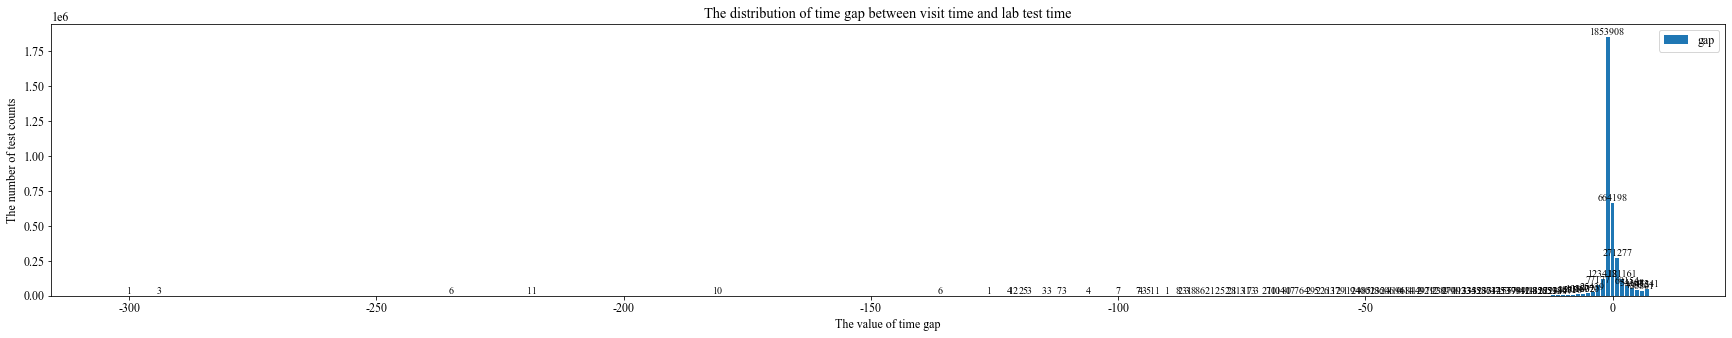

In [ ]:
# check the time gap distribution of old verison of measurement data
db_conn = db_connection('fuo')
visit_gap = db_conn.conn.execute("select gap from p1_measurement_tmp").fetchall()
db_conn.conn.close()
visit_gap = [x for (x,) in visit_gap]
visit_gap = sorted(visit_gap, reverse=True)
visit_gap_unique = sorted(list(set(visit_gap)), reverse=True)
gap_count = {}
for i in visit_gap_unique:
    gap_count[i] = visit_gap.count(i)

gap, count = [], []
for key, value in gap_count.items():
    gap.append(key)
    count.append(value)
#plot
plt.figure(figsize=(30,5))
p1 = plt.bar(gap, count, label='gap')
for a, b in zip(gap, count):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.title('The distribution of time gap between visit time and lab test time')
plt.xlabel('The value of time gap')
plt.ylabel('The number of test counts')
plt.legend()
plt.savefig(os.path.join('./output', '20211220-Distribution of time gap between inhospital and lab test.png'), bbox_inches='tight')
plt.show()

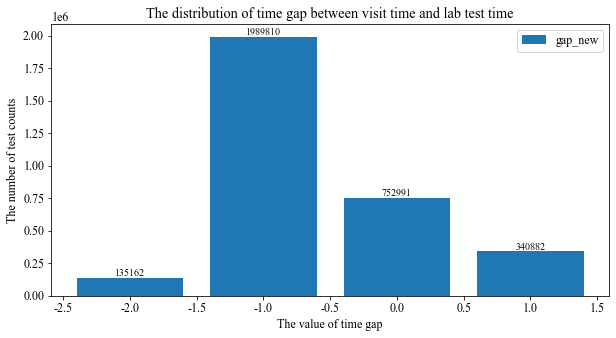

In [ ]:
db_conn = db_connection('fuo')
visit_gap = db_conn.conn.execute("select gap from p1_measurement_24h_tmp_bak").fetchall()
db_conn.conn.close()

visit_gap = [x for (x,) in visit_gap]
visit_gap = sorted(visit_gap, reverse=True)
visit_gap_unique = sorted(list(set(visit_gap)), reverse=True)
gap_count = {}
for i in visit_gap_unique:
    gap_count[i] = visit_gap.count(i)

gap, count = [], []
for key, value in gap_count.items():
    gap.append(key)
    count.append(value)

#plot
plt.figure(figsize=(10,5))
p1 = plt.bar(gap, count, label='gap_new')
for a, b in zip(gap, count):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.title('The distribution of time gap between visit time and lab test time')
plt.xlabel('The value of time gap')
plt.ylabel('The number of test counts')
plt.legend()
plt.savefig(os.path.join('./output', '20211220-Distribution of time gap between inhospital and lab test (new).png'), bbox_inches='tight')
plt.show()

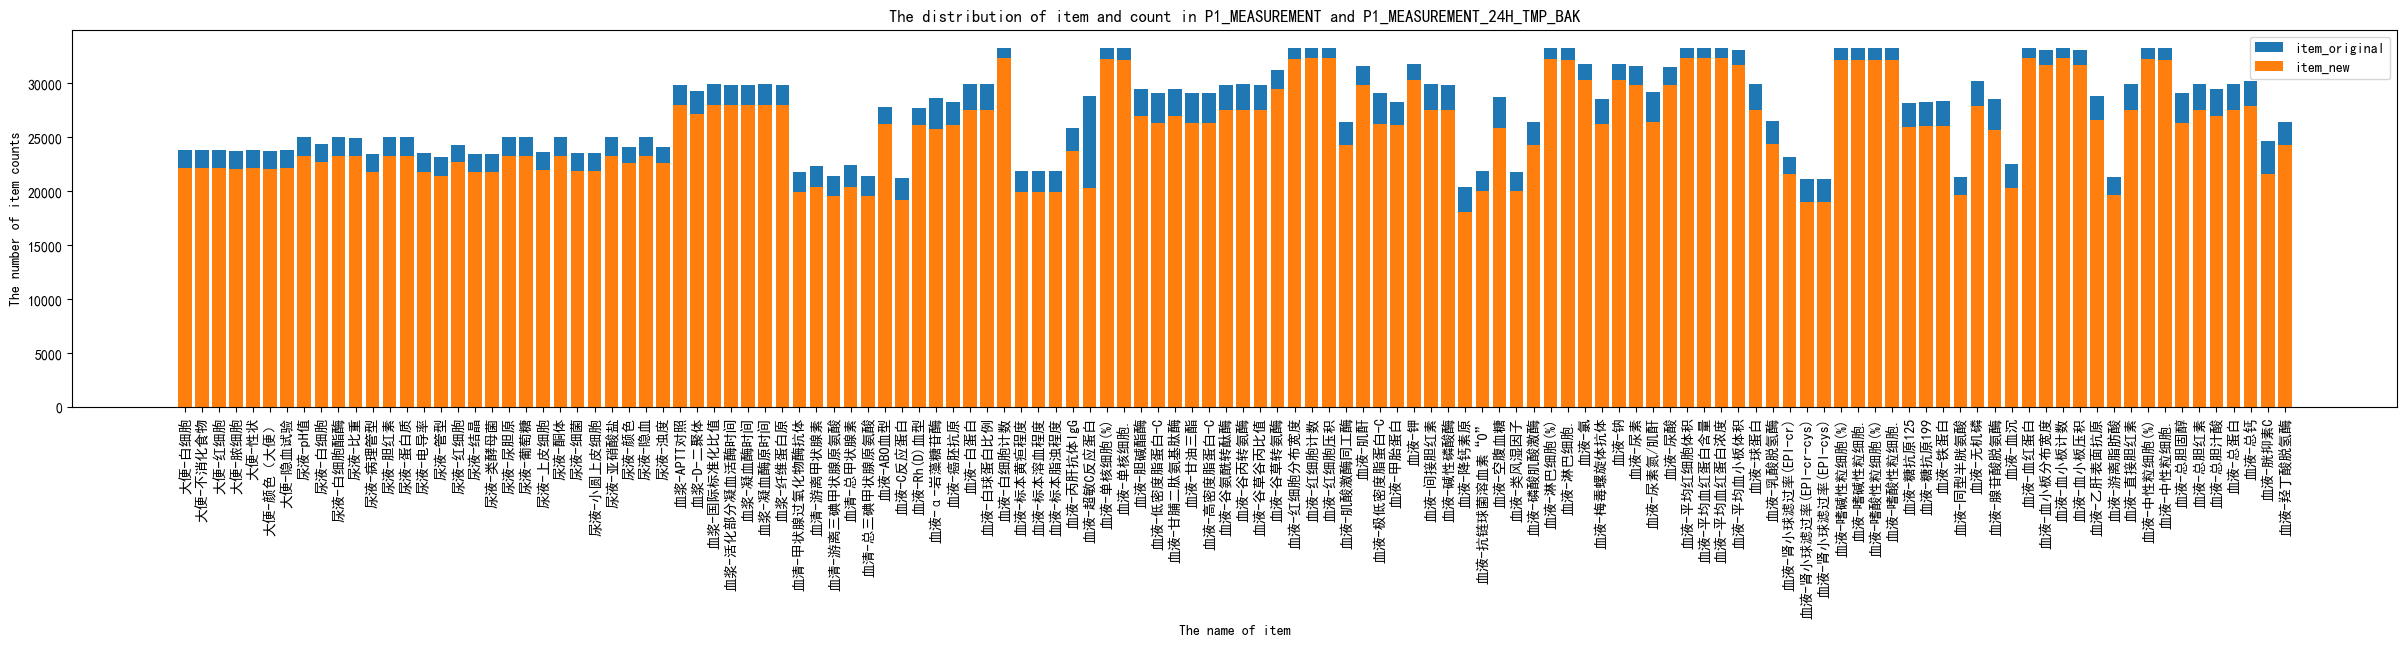

In [ ]:
# get the original item distribution 
db_conn = db_connection('fuo')
result = db_conn.conn.execute("select specimen, item_name, count(distinct visit_record_id_new_1) from p1_measurement group by specimen, item_name order by specimen, item_name").fetchall()
db_conn.conn.close()
item_count_ori = {}
for i in result:
    item_count_ori[''.join((i[0], '-', i[1]))] = i[2]
item_ori, count_ori = [], []
for key, value in item_count_ori.items():
    item_ori.append(key)
    count_ori.append(value)

# get the new item distribution 
db_conn = db_connection('fuo')
result = db_conn.conn.execute("select specimen, item_name, count(distinct visit_record_id_new_1) from p1_measurement_24h_tmp_bak group by specimen, item_name order by specimen, item_name").fetchall()
db_conn.conn.close()
item_count_new = {}
for i in result:
    item_count_new[''.join((i[0], '-', i[1]))] = i[2]
item_new, count_new = [], []
for key, value in item_count_new.items():
    item_new.append(key)
    count_new.append(value)

fig, (ax2) = plt.subplots(1, 1, sharex=True, dpi=100, figsize=(30,5))
ax2.bar(item_ori, count_ori, label='item_original')
ax2.bar(item_new, count_new, label='item_new')
# for a, b in zip(item, count):
#     plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
ax2.tick_params(axis='x', rotation=90)
plt.title('The distribution of item and count in P1_MEASUREMENT and P1_MEASUREMENT_24H_TMP_BAK')
plt.xlabel('The name of item')
plt.ylabel('The number of item counts')
plt.legend()
fig = ax2.get_figure()
fig.savefig(os.path.join('./output', 'Distribution of item count (p1_measurement vs p1_measrement_24h_tmp_bak).png'), bbox_inches='tight')
fig.show()

In [ ]:
# 对化验数据内的异常值进行处理
mp = MeasurementProcess('fuo', 'P1_MEASUREMENT_24H_TMP_BAK', 'P1_MEASUREMENT_24H_VAL', 'P1_MEASUREMENT_24H_CAT')
mp.process_measurement()

-----------------------------------------------------------------------
The original shape of measurement data is (3218845, 13)
-----------------------------------------------------------------------
-----------------------------------------------------------------------
The shapes of measurement data of urine, shit, blood_cat, blood_val are respectively (499967, 13), (155125, 13), (144795, 13), (2418958, 13)
-----------------------------------------------------------------------


/mnt/data/wzx/jupyter_notebook/HC4FUO/src/Preprocessing.py:1529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blood_val['value'] = df_blood_val['value'].replace('[^\d^\.]+', '', regex=True)
/mnt/data/wzx/jupyter_notebook/HC4FUO/src/Preprocessing.py:1530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blood_val['value'] = df_blood_val['value'].replace('\.{2,100}', '.', regex=True)
/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is

-----------------------------------------------------------------------
The shapes of measurement data after processing are (799887, 13)
-----------------------------------------------------------------------


In [2]:
time_start=time.time()
lcv = LabelComplementV2('fuo')
# lcv.processing()
lcv.postProcessing()

time_end=time.time()
print('totally cost',time_end-time_start)

[Info]: The number of visit_record_id is 34051
totally cost 3.015711545944214
